# 1. Environment Setup

In [12]:
# import libraries
import boto3, re, sys, math, json, os, sagemaker, urllib.request
from sagemaker import get_execution_role
import numpy as np                                
import pandas as pd                               
import matplotlib.pyplot as plt                   
from IPython.display import Image                 
from IPython.display import display               
from time import gmtime, strftime                 
from sagemaker.predictor import csv_serializer  

In [13]:
# Define IAM role
role = get_execution_role()

In [3]:
# get it from AWS : algo specific containers
prefix = 'sagemaker/DEMO-xgboost-dm'
containers = {'us-west-2': '433757028032.dkr.ecr.us-west-2.amazonaws.com/xgboost:latest',
              'us-east-1': '811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest',
              'us-east-2': '825641698319.dkr.ecr.us-east-2.amazonaws.com/xgboost:latest',
              'eu-west-1': '685385470294.dkr.ecr.eu-west-1.amazonaws.com/xgboost:latest'} # each region has its XGBoost container
my_region = boto3.session.Session().region_name # set the region of the instance
print("Success - the MySageMakerInstance is in the " + my_region + " region. You will use the " + containers[my_region] + " container for your SageMaker endpoint.")

Success - the MySageMakerInstance is in the us-east-1 region. You will use the 811284229777.dkr.ecr.us-east-1.amazonaws.com/xgboost:latest container for your SageMaker endpoint.


# 2. Data Preparation

In [6]:
# create an S3 bucket that will store modelling data

bucket_name = 'data-basic-pipeline'
s3 = boto3.resource('s3')
try:
    if  my_region == 'us-east-1':
        s3.create_bucket(Bucket=bucket_name)
    else: 
        s3.create_bucket(Bucket=bucket_name, CreateBucketConfiguration={ 'LocationConstraint': my_region })
    print('S3 bucket created successfully')
except Exception as e:
    print('S3 error: ',e)

S3 bucket created successfully


## load raw data

In [8]:
# load raw data
try:
    urllib.request.urlretrieve ("https://d1.awsstatic.com/tmt/build-train-deploy-machine-learning-model-sagemaker/bank_clean.27f01fbbdf43271788427f3682996ae29ceca05d.csv", "bank_clean.csv")
    print('Success: downloaded bank_clean.csv.')
except Exception as e:
    print('Data load error: ',e)

try:
    model_data = pd.read_csv('./bank_clean.csv',index_col=0)
    print('Success: Data loaded into dataframe.')
except Exception as e:
    print('Data load error: ',e)

Success: downloaded bank_clean.csv.
Success: Data loaded into dataframe.


## data pre-processing

In [9]:
# shuffle the data and split it into training data and test data
train_data, test_data = np.split(model_data.sample(frac=1, random_state=1729), [int(0.7 * len(model_data))])
print(train_data.shape, test_data.shape)

(28831, 61) (12357, 61)


In [10]:
# reformat the header and first column of the training data
# load the data from the S3 bucket
pd.concat([train_data['y_yes'], train_data.drop(['y_no', 'y_yes'], axis=1)], axis=1).to_csv('train.csv', index=False, header=False)
boto3.Session().resource('s3').Bucket(bucket_name).Object(os.path.join(prefix, 'train/train.csv')).upload_file('train.csv')
s3_input_train = sagemaker.s3_input(s3_data='s3://{}/{}/train'.format(bucket_name, prefix), content_type='csv')

's3_input' class will be renamed to 'TrainingInput' in SageMaker Python SDK v2.


# 2. Modelling

## load model

In [14]:
# set up the Amazon SageMaker session
sess = sagemaker.Session()

# create an instance of the XGBoost model
xgb = sagemaker.estimator.Estimator(containers[my_region],role, train_instance_count=1, 
                                    train_instance_type='ml.m4.xlarge',
                                    output_path='s3://{}/{}/output'.format(bucket_name, prefix),
                                    sagemaker_session=sess)

# define the model’s hyperparameters
xgb.set_hyperparameters(max_depth=5,eta=0.2,gamma=4,min_child_weight=6,subsample=0.8,
                        silent=0,objective='binary:logistic',num_round=100)

Parameter image_name will be renamed to image_uri in SageMaker Python SDK v2.


## train model

In [15]:
# train the model using gradient optimization on a ml.m4.xlarge instance
xgb.fit({'train': s3_input_train})

2020-09-02 06:37:41 Starting - Starting the training job...
2020-09-02 06:37:44 Starting - Launching requested ML instances.........
2020-09-02 06:39:29 Starting - Preparing the instances for training......
2020-09-02 06:40:31 Downloading - Downloading input data
2020-09-02 06:40:31 Training - Downloading the training image..Arguments: train
[2020-09-02:06:40:52:INFO] Running standalone xgboost training.
[2020-09-02:06:40:52:INFO] Path /opt/ml/input/data/validation does not exist!
[2020-09-02:06:40:52:INFO] File size need to be processed in the node: 3.38mb. Available memory size in the node: 8511.52mb
[2020-09-02:06:40:52:INFO] Determined delimiter of CSV input is ','
[06:40:52] S3DistributionType set as FullyReplicated
[06:40:52] 28831x59 matrix with 1701029 entries loaded from /opt/ml/input/data/train?format=csv&label_column=0&delimiter=,
[06:40:52] src/tree/updater_prune.cc:74: tree pruning end, 1 roots, 30 extra nodes, 14 pruned nodes, max_depth=5
[0]#011train-error:0.100482
[06:4

# 3. Deployement

In [ ]:
# deploy the model on a server and create an endpoint that you can access
xgb_predictor = xgb.deploy(initial_instance_count=1,instance_type='ml.m4.xlarge')

# 4. Evaluation

In [19]:
# predict whether customers in the test data enrolled or not
test_data_array = test_data.drop(['y_no', 'y_yes'], axis=1).values #load the data into an array
xgb_predictor.content_type = 'text/csv' # set the data type for an inference
xgb_predictor.serializer = csv_serializer # set the serializer type
predictions = xgb_predictor.predict(test_data_array).decode('utf-8') # predict!
predictions_array = np.fromstring(predictions[1:], sep=',') # and turn the prediction into an array
print(predictions_array.shape)

(12357,)


## confusion matrix

In [18]:
cm = pd.crosstab(index=test_data['y_yes'], columns=np.round(predictions_array), rownames=['Observed'], colnames=['Predicted'])
tn = cm.iloc[0,0]; fn = cm.iloc[1,0]; tp = cm.iloc[1,1]; fp = cm.iloc[0,1]; p = (tp+tn)/(tp+tn+fp+fn)*100
print("\n{0:<20}{1:<4.1f}%\n".format("Overall Classification Rate: ", p))
print("{0:<15}{1:<15}{2:>8}".format("Predicted", "No Purchase", "Purchase"))
print("Observed")
print("{0:<15}{1:<2.0f}% ({2:<}){3:>6.0f}% ({4:<})".format("No Purchase", tn/(tn+fn)*100,tn, fp/(tp+fp)*100, fp))
print("{0:<16}{1:<1.0f}% ({2:<}){3:>7.0f}% ({4:<}) \n".format("Purchase", fn/(tn+fn)*100,fn, tp/(tp+fp)*100, tp))


Overall Classification Rate: 89.5%

Predicted      No Purchase    Purchase
Observed
No Purchase    90% (10785)    35% (151)
Purchase        10% (1143)     65% (278) 



## PR curve

In [49]:
from sklearn.metrics import precision_recall_curve
from sklearn.metrics import plot_precision_recall_curve
from sklearn.metrics import average_precision_score
import matplotlib.pyplot as plt

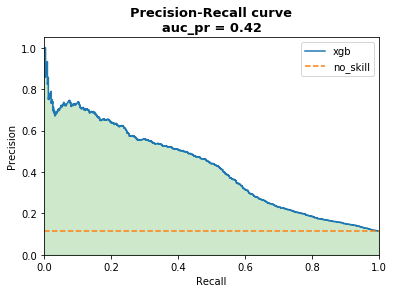

In [55]:
y = test_data['y_yes'].values

# predict probabilities
yhat = predictions_array
pos_probs = predictions_array

# calculate the no skill line as the proportion of the positive class
no_skill = len(y[y==1]) / len(y)

average_precision = average_precision_score(y, yhat)

precision, recall, _ = precision_recall_curve(y, pos_probs)
plt.plot(recall, precision, label='xgb')
plt.fill_between(recall, precision, alpha=0.2, color='#0B8E04')

plt.plot([0, 1], [no_skill, no_skill], label='no_skill', linestyle='--')

plt.ylim([0.0, 1.05])
plt.xlim([0.0, 1.0])
plt.title('Precision-Recall curve\nauc_pr = {0:0.2f}'.format(average_precision), fontweight='bold', fontsize=13)
    
plt.xlabel('Recall')
plt.ylabel('Precision')
plt.legend()
plt.show()

# 5. Prediction

# Terminate Resources

In [ ]:
# Terminate your resources
sagemaker.Session().delete_endpoint(xgb_predictor.endpoint)
bucket_to_delete = boto3.resource('s3').Bucket(bucket_name)
bucket_to_delete.objects.all().delete()

In [56]:
test_data_array.shape

(12357, 59)

In [57]:
test_data_array[0]

array([ 29,   2, 999,   0,   1,   0,   0,   1,   0,   0,   0,   0,   0,
         0,   0,   0,   0,   0,   0,   1,   0,   0,   0,   0,   1,   0,
         0,   0,   0,   0,   1,   0,   0,   1,   0,   0,   1,   0,   0,
         0,   1,   0,   0,   0,   0,   1,   0,   0,   0,   0,   0,   0,
         0,   0,   1,   0,   0,   1,   0])